In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
import numpy as np
%matplotlib inline

## Import Boston Dataset

In [2]:
boston = load_boston()
# House Prices
y = boston.target
# The other 13 features
x = boston.data

In [3]:
x.shape

(506, 13)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Instansiate Models

In [5]:
rf = RandomForestRegressor(n_estimators=100,
                          n_jobs=-1,
                          random_state=1)

gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                loss='ls',
                                n_estimators=100,
                                random_state=1)

abr = AdaBoostRegressor(DecisionTreeRegressor(),
                       learning_rate=0.1,
                       loss='linear',
                       n_estimators=100,
                       random_state=1)

## Cross Validation Helper Function

In [6]:
def cross_val_MSE_R2(estimator_list):
    MSE_list = []
    R2_list = []

    for estimator in estimator_list: 
        MSE = - np.mean(cross_val_score(estimator,
                                        X_train, y_train,
                                        scoring="mean_squared_error",
                                        cv= 10,
                                        n_jobs=-1))
        R2 = np.mean(cross_val_score(estimator,
                              X_train, y_train,
                              scoring="r2",
                              cv= 10,
                              n_jobs=-1))

        MSE_list.append(MSE)
        R2_list.append(R2)
    
    return MSE_list, R2_list

## Model Comparison

In [7]:
estimator_list = [rf, gdbr, abr]

MSE_list, R2_list = cross_val_MSE_R2(estimator_list)

for i, est in enumerate(["Random Forest", "Gradient Boosting", "AdaBoost"]):
    print "{} => MSE: {:0.2f}, R2: {:0.2f}".format(str(est), MSE_list[i], R2_list[i])

Random Forest => MSE: 9.88, R2: 0.87
Gradient Boosting => MSE: 8.45, R2: 0.89
AdaBoost => MSE: 10.33, R2: 0.86


Gradient Boosting has the best cross validation score. However, to make a better judgement  of the performance we need to test these models on the hold-out dataset, because these data has never been seen by the model and therefore is unbaised.

## Gradient Boosting Regressor with Learning Rate Increased to 1

In [8]:
gdbr1 = GradientBoostingRegressor(learning_rate=1,
                                loss='ls',
                                n_estimators=100,
                                random_state=1)

In [9]:
MSE, R2 = cross_val_MSE_R2([gdbr1])

print "Gradient Boosting (learning rate = 1) => MSE: {:0.2f}, R2: {:0.2f}".format(MSE[0], R2[0])

Gradient Boosting (learning rate = 1) => MSE: 21.01, R2: 0.73


With this higher learning rate the model performance decreases. Let's investiagte that further.

## Graph Boosting Iteration

In [10]:
def stage_score_plot(model, X_train, X_test, y_train, y_test):
    '''
    INPUT:
      model: GradientBoostingRegressor or AdaBoostRegressor
      train_x: 2d numpy array
      train_y: 1d numpy array
      test_x: 2d numpy array
      test_y: 1d numpy array

    Create a plot of the number of iterations vs the MSE for the model for
    both the training set and test set.
    '''
    model.fit(X_train, y_train)

    lr = model.learning_rate

    train_score = []
    for i, train_pred_y in enumerate(model.staged_predict(X_train)):
        train_score.append(mean_squared_error(y_train, train_pred_y))

    test_score = []
    for i, test_pred_y in enumerate(model.staged_predict(X_test)):
        test_score.append(mean_squared_error(y_test, test_pred_y))

    #plt.figure(figsize=(8, 8))
    plt.title(model.__class__.__name__)
    plt.plot(range(len(train_score)), train_score, '--',
             label= model.__class__.__name__ + ' Train: learning rate = ' + str(lr))
    plt.plot(range(len(test_score)), test_score, 
             label= model.__class__.__name__ + ' Test: learning rate = ' + str(lr))
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('MSE')

## Train and Test Error for LEarning Rate of 0.1 and 1

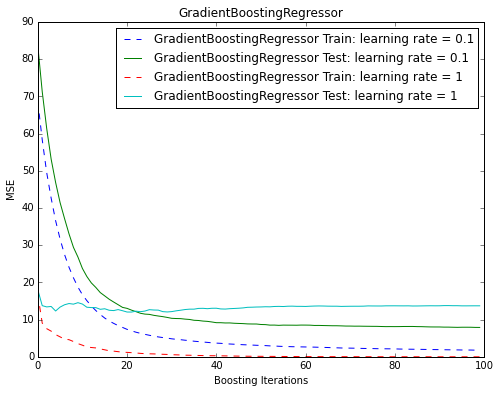

In [17]:
plt.figure(figsize=(8, 6))
stage_score_plot(gdbr, X_train, X_test, y_train, y_test)
stage_score_plot(gdbr1, X_train, X_test, y_train, y_test)
plt.show()

As expected the train error is always smaller than the test error for both learning rates. This is because the train error is an "optimistic" measure of model performance, but in fact it is overfitting. The higher learning rate allows the train error to converge faster. However a too high learning rate makes the test error diverge. The large steps overshot the minima. A lower learning rate allows to get a lower test error after about 25 boosting iterations

## Add Random Forest MSE to Gradient Boosting Graph

In [13]:
rfMSE, _ = cross_val_MSE_R2([rf])

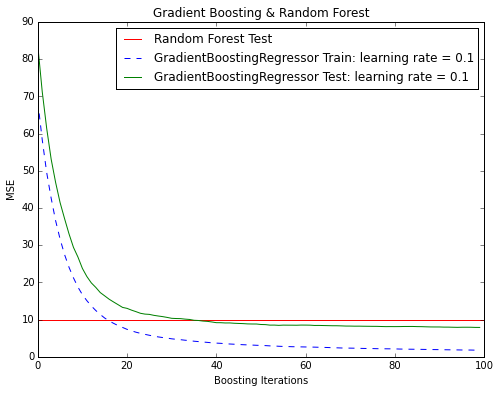

In [14]:
plt.figure(figsize=(8, 6))
plt.axhline(y=rfMSE, color='r',label = 'Random Forest Test')

stage_score_plot(gdbr, X_train, X_test, y_train, y_test)
plt.title("Gradient Boosting & Random Forest")
plt.show()

Gradient Boosting beats Random Forest at about 40 boosting iterations

## Add Random Forest MSE to AdaBoosting Graph

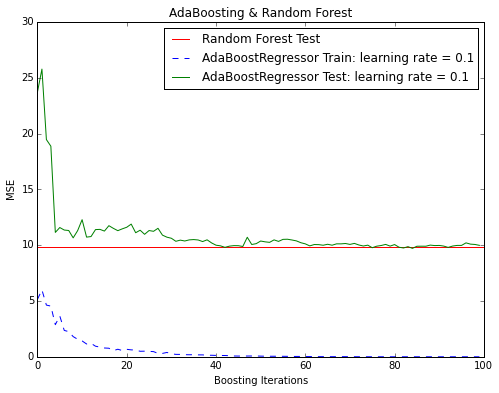

In [16]:
plt.figure(figsize=(8, 6))
plt.axhline(y=rfMSE, color='r', label = 'Random Forest Test')
stage_score_plot(abr, X_train, X_test, y_train, y_test)
plt.title("AdaBoosting & Random Forest")
plt.show()

AdaBoosting and Random Forest seem to converge to a very similar value at around 40 boosting iterations.

## Grid Search

In [34]:
random_forest_grid = {'max_depth': [5, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [3, 4, 5],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [30, 40, 50],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='mean_squared_error')
rf_gridsearch.fit(X_train, y_train)

print "best parameters:", rf_gridsearch.best_params_
print "Best score: ", rf_random_search.best_score_

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 966 out of 972 | elapsed:   15.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   15.1s finished


best parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 30, 'min_samples_split': 3, 'random_state': 1, 'max_features': 'sqrt', 'max_depth': None}
Best score:  0.838345473025


## Grid Search Random Forest Performance

In [21]:
# Best parameters
rf_best = RandomForestRegressor(bootstrap = False, 
                               min_samples_leaf = 1,
                               n_estimators = 30,
                               min_samples_split = 3,
                               random_state = 1,
                               max_features = 'sqrt',
                               max_depth = None)

In [22]:
MSE, R2 = cross_val_MSE_R2([rf_best])

print "Random Forest => MSE: {:0.2f}, R2: {:0.2f}".format(MSE[0], R2[0])

Random Forest => MSE: 9.19, R2: 0.88


The tuned Random Forest was able to achieve a slightly better to the default parameters that got a MSE 9.88.

## Random Search

In [70]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 14),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(10, 60),
              "random_state": [1]}

# run randomized search
n_iter_search = 200
rf_random_search = RandomizedSearchCV(RandomForestRegressor(),
                                       param_distributions=param_dist,
                                       n_iter=n_iter_search,
                                       n_jobs=-1,
                                       verbose=True)

rf_random_search.fit(X_train, y_train)

print "best parameters:", rf_random_search.best_params_
print "Best score: ", rf_random_search.best_score_

best_rf_model = rf_random_search.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 594 out of 600 | elapsed:    7.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    8.0s finished


best parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 36, 'min_samples_split': 4, 'random_state': 1, 'max_features': 4, 'max_depth': None}
Best score:  0.883605620995


## Random Search Random Forest Performance

In [72]:
rf_best = RandomForestRegressor(bootstrap = False, 
                               min_samples_leaf = 1,
                               n_estimators = 53,
                               min_samples_split = 3,
                               random_state = 1,
                               max_features = 5,
                               max_depth = None)

MSE, R2 = cross_val_MSE_R2([rf_best])

print "Random Forest => MSE: {:0.2f}, R2: {:0.2f}".format(MSE[0], R2[0])

Random Forest => MSE: 8.43, R2: 0.89


With a random search we get an improved MSE and R2.

## Gradient Boosting Grid Search

In [95]:
param_grid = {'n_estimators': [200],
              'min_samples_leaf': [2, 3, 4, 5],
              'max_depth': [3, 5, 7, 8],
              'max_features': ['sqrt', 'log2', None],
              'learning_rate': [0.05, 0.02, 0.01]}

gd_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             param_grid = param_grid,
                             n_jobs=-1,
                             verbose=True)

gd_gridsearch.fit(X_train, y_train)

print "best parameters:", gd_gridsearch.best_params_
print "Best score: ", gd_gridsearch.best_score_

best_rf_model = gd_gridsearch.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   16.3s finished


best parameters: {'max_features': 'log2', 'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 4}
Best score:  0.889242422317


In [97]:
gdbr_best = GradientBoostingRegressor(learning_rate=0.05,
                                      max_features = 'log2',
                                      n_estimators = 200,
                                      max_depth = 5,
                                      min_samples_leaf = 2,
                                      random_state=1)

MSE, R2 = cross_val_MSE_R2([gdbr_best])

print "Gradient Boosting => MSE: {:0.2f}, R2: {:0.3f}".format(MSE[0], R2[0])

Gradient Boosting => MSE: 8.84, R2: 0.884


The tuned GradientBoosting got a slightly worse result than the default parameters that got a MSE 8.45.

## Gradient Boosting Random Search

In [138]:
param_dist = {'n_estimators': [200],
              'min_samples_leaf': sp_randint(1, 11),
              'max_depth': sp_randint(1, 11),
              'max_features': sp_randint(1, 14),
              'learning_rate': [0.05, 0.03, 0.01]}


# run randomized search
n_iter_search = 200
gb_random_search = RandomizedSearchCV(GradientBoostingRegressor(),
                                       param_distributions=param_dist,
                                       n_iter=n_iter_search,
                                       n_jobs=-1,
                                       verbose=True)

gb_random_search.fit(X_train, y_train)

print "best parameters:", gb_random_search.best_params_
print "Best score: ", gb_random_search.best_score_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 594 out of 600 | elapsed:   20.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   20.5s finished


best parameters: {'max_features': 4, 'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 4}
Best score:  0.893411778663


In [134]:
gdbr_best = GradientBoostingRegressor(learning_rate=0.05,
                                      max_features = 5,
                                      n_estimators = 200,
                                      max_depth = 5,
                                      min_samples_leaf = 4,
                                      random_state=1)

MSE, R2 = cross_val_MSE_R2([gdbr_best])

print "Gradient Boosting => MSE: {:0.2f}, R2: {:0.3f}".format(MSE[0], R2[0])

Gradient Boosting => MSE: 8.10, R2: 0.890


With a Random Search we were able to tune the Gradient Boosting to perform better than the default model.

## Ada Boosting Grid Search

In [150]:
param_grid = {'n_estimators': [200],
              'learning_rate': [0.06, 0.05, 0.03],
              'base_estimator__max_depth': [5, None],
              'base_estimator__max_features': ['sqrt', 'log2', None],
              'base_estimator__min_samples_split': [3, 4, 5],
              'base_estimator__min_samples_leaf': [1, 2, 4]}

DTC = DecisionTreeRegressor(random_state = 1)

gd_gridsearch = GridSearchCV(AdaBoostRegressor(base_estimator = DTC),
                             param_grid = param_grid,
                             n_jobs=-1,
                             verbose=True)

gd_gridsearch.fit(X_train, y_train)

print "best parameters:", gd_gridsearch.best_params_
print "Best score: ", gd_gridsearch.best_score_

best_rf_model = gd_gridsearch.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 480 out of 486 | elapsed:   41.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:   42.5s finished


best parameters: {'base_estimator__min_samples_split': 3, 'base_estimator__max_depth': None, 'learning_rate': 0.05, 'base_estimator__max_features': None, 'n_estimators': 200, 'base_estimator__min_samples_leaf': 2}
Best score:  0.883466098923


In [151]:


adb_best = AdaBoostRegressor(DecisionTreeRegressor(min_samples_split = 3,
                                                   max_depth = None,
                                                   max_features = None,
                                                   min_samples_leaf = 2,),                                                  
                            learning_rate=0.05,
                            n_estimators=200,
                            random_state=1)

MSE, R2 = cross_val_MSE_R2([adb_best])

print "Gradient Boosting => MSE: {:0.2f}, R2: {:0.3f}".format(MSE[0], R2[0])

Gradient Boosting => MSE: 9.83, R2: 0.866


Grid Search on the AdaBoost obtained a better MSE than the default model (MSE: 10.33). 

# Implementation of AdaBoosting Classifer

## Boosing Implementation in bossting.py

In [9]:
cd code

[Errno 2] No such file or directory: 'code'
/Users/marvinbertin/Github/GalvanizeU/DSCI6003-student/week6/6.1/boosting_practicum/code


## Comparing my implementation to sklearn's

In [8]:
!python run_boosting.py

Accurracy of my adaboost: 0.946133796699
Accuracy of sklearn: 0.943527367507
